In [1]:
import pandas as pd
import gc 
import warnings
import numpy as np
from datetime import timedelta
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster
from sklearn.cluster import KMeans
import geopandas as gpd
import seaborn as sns
from bokeh.plotting import figure, show
from datetime import timedelta
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import save, reset_output, output_notebook
from pandas.plotting import parallel_coordinates
from math import log
import datetime as dt
from folium.plugins import HeatMap
from sklearn.preprocessing import KBinsDiscretizer
import sklearn.metrics as metrics

## 1. Preprocessing the dataset for yellow dataset:  

In [2]:
file_path = r"F:\Ads_projects\project1\mast30034_2021_s2_project_1-junzhin\data\2019\yellow_taxi_2019\yellow_2019_01_04_preprocessed_3.feather"
yellow_2019_df = pd.read_feather(file_path)

In [3]:
yellow_2019_df.head()

,index,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,pick_date_time,drop_date_time,...,travel_duration_in_seconds,year,month,date,day,time,week,day_of_week,month_in_words,Borough
0,0,1,1.50,151,239,7.0,1.65,9.95,2019-01-01 00:46:40+00:00,2019-01-01 00:53:20+00:00,...,400,2019,1,2019-01-01,1,00:46:40,1,Tuesday,Jan,Manhattan
1,1,1,1.20,151,239,7.0,1.55,9.35,2019-01-31 09:19:15+00:00,2019-01-31 09:27:00+00:00,...,465,2019,1,2019-01-31,31,09:19:15,5,Thursday,Jan,Manhattan
2,2,1,0.40,151,238,3.5,0.85,5.15,2019-01-31 10:41:17+00:00,2019-01-31 10:43:07+00:00,...,110,2019,1,2019-01-31,31,10:41:17,5,Thursday,Jan,Manhattan
3,3,1,3.80,151,48,16.0,3.35,20.15,2019-01-31 10:07:27+00:00,2019-01-31 10:25:37+00:00,...,1090,2019,1,2019-01-31,31,10:07:27,5,Thursday,Jan,Manhattan
4,4,1,1.55,151,239,7.0,1.56,9.36,2019-01-31 10:02:50+00:00,2019-01-31 10:09:26+00:00,...,396,2019,1,2019-01-31,31,10:02:50,5,Thursday,Jan,Manhattan


In [80]:
yellow_2019_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19076923 entries, 0 to 19076922
Data columns (total 26 columns):
 #   Column                      Dtype              
---  ------                      -----              
 0   index                       int64              
 1   passenger_count             int64              
 2   trip_distance               float64            
 3   PULocationID                int64              
 4   DOLocationID                int64              
 5   fare_amount                 float64            
 6   tip_amount                  float64            
 7   total_amount                float64            
 8   pick_date_time              datetime64[ns, UTC]
 9   drop_date_time              datetime64[ns, UTC]
 10  travel_duration             timedelta64[ns]    
 11  average_speed               float64            
 12  average_fare                float64            
 13  tip_fare_r                  float64            
 14  travel_duration_in_seconds  int3

In [4]:
yellow_2019_df.shape

(19076923, 24)

In [5]:
# import pandas as pd
# import numpy as np
# ewma = pd.DataFrame.ewm

# # make a hat function, and add noise
# x = np.linspace(0,1,100)
# x = np.hstack((x,x[::-1]))
# x += np.random.normal( loc=0, scale=0.1, size=200 )
# plt.plot( x, alpha=0.4, label='Raw' )

# # take EWMA in both directions with a smaller span term
# fwd = ewma( x, span=15 )          # take EWMA in fwd direction
# bwd = ewma( x[::-1], span=15 )    # take EWMA in bwd direction
# c = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
# c = np.mean( c, axis=0 )          # average  

# # regular EWMA, with bias against trend
# plt.plot( ewma( x, span=20 ), 'b', label='EWMA, span=20' )

# # "corrected" (?) EWMA
# plt.plot( c, 'r', label='Reversed-Recombined' )

# legend(loc=8)
# savefig( 'ewma_correction.png', fmt='png', dpi=100 )

## Help function to evaluate the results:

cited from:http://www.edscave.com/forecasting---time-series-metrics.html#:~:text=The%20most%20commonly%20encountered%20relative,useful%20as%20an%20overall%20accuracy.

In [6]:

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## Choosing the locations to performing on the demand by ranking the size of dataset for a particular region

In [7]:
yellow_2019_df[yellow_2019_df['year'] == 2019]
yellow_2019_df['hour']  = yellow_2019_df['pick_date_time'].dt.hour
yellow_2019_df['weekday']  = yellow_2019_df['pick_date_time'].dt.weekday
yellow_2019_df.head()

,index,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,pick_date_time,drop_date_time,...,month,date,day,time,week,day_of_week,month_in_words,Borough,hour,weekday
0,0,1,1.50,151,239,7.0,1.65,9.95,2019-01-01 00:46:40+00:00,2019-01-01 00:53:20+00:00,...,1,2019-01-01,1,00:46:40,1,Tuesday,Jan,Manhattan,0,1
1,1,1,1.20,151,239,7.0,1.55,9.35,2019-01-31 09:19:15+00:00,2019-01-31 09:27:00+00:00,...,1,2019-01-31,31,09:19:15,5,Thursday,Jan,Manhattan,9,3
2,2,1,0.40,151,238,3.5,0.85,5.15,2019-01-31 10:41:17+00:00,2019-01-31 10:43:07+00:00,...,1,2019-01-31,31,10:41:17,5,Thursday,Jan,Manhattan,10,3
3,3,1,3.80,151,48,16.0,3.35,20.15,2019-01-31 10:07:27+00:00,2019-01-31 10:25:37+00:00,...,1,2019-01-31,31,10:07:27,5,Thursday,Jan,Manhattan,10,3
4,4,1,1.55,151,239,7.0,1.56,9.36,2019-01-31 10:02:50+00:00,2019-01-31 10:09:26+00:00,...,1,2019-01-31,31,10:02:50,5,Thursday,Jan,Manhattan,10,3


In [8]:
yellow_2019_df["PULocationID"].value_counts().sort_values()[::-1]

237    854978
161    841682
236    826765
162    768572
234    688122
        ...  
104         1
115         1
176         1
204         1
46          1
Name: PULocationID, Length: 257, dtype: int64

##  Location IDs of  237, 138[which is the LaGuardia Airport ]for prediction modelling.

In [9]:
yellow_2019_136 = yellow_2019_df[yellow_2019_df["PULocationID"] == 237]

## Assign each trip with a time bin in the period of 2019/01-2019-/04


In [10]:
yellow_2019_136["time_bin_hour"]  = pd.cut(yellow_2019_136["pick_date_time"], bins=2880)
yellow_2019_136 = yellow_2019_136.drop(['PULocationID','DOLocationID','day_of_week','month_in_words'],axis = 1)
yellow_2019_136.head()

,index,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,pick_date_time,drop_date_time,travel_duration,average_speed,...,year,month,date,day,time,week,Borough,hour,weekday,time_bin_hour
1179322,1189359,1,0.96,8.0,1.76,10.56,2019-01-31 09:39:20+00:00,2019-01-31 09:49:39+00:00,0 days 00:10:19,5.583199,...,2019,1,2019-01-31,31,09:39:20,5,Manhattan,9,3,"(2019-01-31 08:51:49.703124992, 2019-01-31 09:..."
1179323,1189360,1,1.21,9.5,1.54,11.84,2019-01-31 09:55:58+00:00,2019-01-31 10:09:48+00:00,0 days 00:13:50,5.248193,...,2019,1,2019-01-31,31,09:55:58,5,Manhattan,9,3,"(2019-01-31 09:51:19.633333248, 2019-01-31 10:..."
1179324,1189361,1,1.30,8.0,1.76,10.56,2019-01-31 09:43:15+00:00,2019-01-31 09:53:28+00:00,0 days 00:10:13,7.634584,...,2019,1,2019-01-31,31,09:43:15,5,Manhattan,9,3,"(2019-01-31 08:51:49.703124992, 2019-01-31 09:..."
1179325,1189362,1,7.98,32.0,6.56,39.36,2019-01-31 09:42:21+00:00,2019-01-31 10:20:33+00:00,0 days 00:38:12,12.534031,...,2019,1,2019-01-31,31,09:42:21,5,Manhattan,9,3,"(2019-01-31 08:51:49.703124992, 2019-01-31 09:..."
1179326,1189363,1,0.96,9.5,2.06,12.36,2019-01-31 09:27:15+00:00,2019-01-31 09:41:40+00:00,0 days 00:14:25,3.995376,...,2019,1,2019-01-31,31,09:27:15,5,Manhattan,9,3,"(2019-01-31 08:51:49.703124992, 2019-01-31 09:..."


In [11]:
yellow_2019_136_grouping_df = yellow_2019_136.groupby("time_bin_hour").mean()
yellow_2019_136_grouping_df = yellow_2019_136_grouping_df.drop(['index'], axis = 1)

In [12]:
yellow_2019_136_grouping_df['year'] = yellow_2019_136_grouping_df['year'].astype(int)
yellow_2019_136_grouping_df['month'] = yellow_2019_136_grouping_df['month'].astype(int)
yellow_2019_136_grouping_df['day'] = yellow_2019_136_grouping_df['day'].astype(int)
yellow_2019_136_grouping_df['week'] = yellow_2019_136_grouping_df['week'].astype(int)
yellow_2019_136_grouping_df['weekday'] = yellow_2019_136_grouping_df['weekday'].astype(int)
yellow_2019_136_grouping_df['hour'] = yellow_2019_136_grouping_df['hour'].astype(int)
yellow_2019_136_grouping_df['travel_duration_in_seconds'] = yellow_2019_136_grouping_df['travel_duration_in_seconds'].astype(int)
yellow_2019_136_grouping_df.head(5)

,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,year,month,day,week,hour,weekday
time_bin_hour,,,,,,,,,,,,,,,
"(2018-12-31 21:08:49.600999936, 2019-01-01 00:59:40.930208256]",1.670213,2.067589,9.698582,2.240567,13.237376,12.458827,5.431296,0.249206,638,2019,1,1,1,0,1
"(2019-01-01 00:59:40.930208256, 2019-01-01 01:59:10.860416768]",1.746377,2.479891,10.842391,2.413261,14.607283,12.651584,5.108188,0.230607,715,2019,1,1,1,1,1
"(2019-01-01 01:59:10.860416768, 2019-01-01 02:58:40.790625024]",1.558140,2.353566,9.965116,2.144651,13.445349,13.992693,5.202503,0.228386,604,2019,1,1,1,1,1
"(2019-01-01 02:58:40.790625024, 2019-01-01 03:58:10.720833280]",1.789474,2.558421,10.333333,2.286140,13.910702,15.400600,4.642555,0.227293,607,2019,1,1,1,2,1
"(2019-01-01 03:58:10.720833280, 2019-01-01 04:57:40.651041792]",2.068966,3.113448,11.275862,2.266552,15.438276,18.557337,4.398957,0.229319,576,2019,1,1,1,3,1


In [13]:
yellow_count_df = pd.DataFrame(yellow_2019_136['time_bin_hour'].value_counts())
yellow_count_df['frequency'] =  yellow_count_df['time_bin_hour'] 
yellow_count_df= yellow_count_df.drop(['time_bin_hour'] , axis = 1)
yellow_count_df = yellow_count_df.reset_index()
yellow_2019_136_grouping_df = yellow_2019_136_grouping_df.reset_index()
yellow_2019_136_grouping_df = pd .merge(yellow_count_df,yellow_2019_136_grouping_df,\
                                        left_on = 'index' ,\
                                        right_on = 'time_bin_hour')
yellow_2019_136_grouping_df = yellow_2019_136_grouping_df.drop('index', axis = 1).set_index('time_bin_hour')

yellow_2019_136_grouping_df

,frequency,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,year,month,day,week,hour,weekday
time_bin_hour,,,,,,,,,,,,,,,,
"(2019-04-25 17:48:27.188541696, 2019-04-25 18:47:57.118749952]",802,1.557357,1.574788,9.493142,2.456297,16.259090,8.636411,7.041923,0.285199,726,2019,4,25,17,17,3
"(2019-03-06 17:54:51.636458240, 2019-03-06 18:54:21.566666752]",778,1.619537,1.652172,9.222365,2.457866,16.000938,8.936332,6.606290,0.286147,680,2019,3,6,10,17,2
"(2019-01-29 18:11:22.424999936, 2019-01-29 19:10:52.355208448]",777,1.498069,1.528069,8.862934,1.998082,12.664994,8.369449,6.923804,0.238105,661,2019,1,29,5,18,1
"(2019-03-07 17:42:49.961458432, 2019-03-07 18:42:19.891666688]",768,1.524740,1.562357,9.034505,2.413828,15.748203,8.850831,6.646415,0.285483,672,2019,3,7,10,17,3
"(2019-02-06 17:34:38.955208448, 2019-02-06 18:34:08.885416704]",751,1.619174,1.553222,9.340213,2.505379,16.158202,8.279520,6.957398,0.286805,721,2019,2,6,6,17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2019-01-07 02:46:00.670833408, 2019-01-07 03:45:30.601041664]",2,1.000000,2.650000,10.000000,2.255000,13.555000,17.809723,4.166667,0.228187,504,2019,1,7,2,2,0
"(2019-04-21 04:43:34.865625088, 2019-04-21 05:43:04.795833344]",2,1.000000,4.995000,15.000000,3.430000,25.290000,29.672720,3.650906,0.271132,523,2019,4,21,16,4,6
"(2019-04-23 03:20:01.585416704, 2019-04-23 04:19:31.515624960]",1,1.000000,1.290000,5.500000,0.750000,10.050000,26.237288,4.263566,0.136364,177,2019,4,23,17,3,1


NameError: name 'y_prediction' is not defined

## Feature Engineering

In [14]:
yellow_2019_136_grouping_df['indicator_peak_hours']  = yellow_2019_136_grouping_df['hour'].map(lambda x: 1 if x in [9,10,11,12,13,14,15,16,17,18,19,20] else 0)
yellow_2019_136_grouping_df['indicator_weekends']  = yellow_2019_136_grouping_df['weekday'].map(lambda x: 1 if x in [5,6] else 0)
yellow_2019_136_grouping_df.head()                                                        

,frequency,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,year,month,day,week,hour,weekday,indicator_peak_hours,indicator_weekends
time_bin_hour,,,,,,,,,,,,,,,,,,
"(2019-04-25 17:48:27.188541696, 2019-04-25 18:47:57.118749952]",802,1.557357,1.574788,9.493142,2.456297,16.259090,8.636411,7.041923,0.285199,726,2019,4,25,17,17,3,1,0
"(2019-03-06 17:54:51.636458240, 2019-03-06 18:54:21.566666752]",778,1.619537,1.652172,9.222365,2.457866,16.000938,8.936332,6.606290,0.286147,680,2019,3,6,10,17,2,1,0
"(2019-01-29 18:11:22.424999936, 2019-01-29 19:10:52.355208448]",777,1.498069,1.528069,8.862934,1.998082,12.664994,8.369449,6.923804,0.238105,661,2019,1,29,5,18,1,1,0
"(2019-03-07 17:42:49.961458432, 2019-03-07 18:42:19.891666688]",768,1.524740,1.562357,9.034505,2.413828,15.748203,8.850831,6.646415,0.285483,672,2019,3,7,10,17,3,1,0
"(2019-02-06 17:34:38.955208448, 2019-02-06 18:34:08.885416704]",751,1.619174,1.553222,9.340213,2.505379,16.158202,8.279520,6.957398,0.286805,721,2019,2,6,6,17,2,1,0


## Create columns that keep the demand from the past

In [15]:
yellow_2019_136_grouping_df = yellow_2019_136_grouping_df.sort_values(["time_bin_hour"],ascending =  False)
yellow_2019_136_grouping_df['t+1 frequency'] = yellow_2019_136_grouping_df.loc[:,'frequency'].shift(periods=1)

yellow_2019_136_grouping_df['t-1 frequency'] = yellow_2019_136_grouping_df.loc[:,'frequency'].shift(periods=-1)
yellow_2019_136_grouping_df['t-1 frequency_diff'] = yellow_2019_136_grouping_df.loc[:,'t-1 frequency'].diff(periods = -1)


yellow_2019_136_grouping_df['t-2 frequency'] = yellow_2019_136_grouping_df.loc[:,'t-1 frequency'].shift(periods=-1)
yellow_2019_136_grouping_df['t-2 frequency_diff'] = yellow_2019_136_grouping_df.loc[:,'t-2 frequency'].diff(periods = -1)

yellow_2019_136_grouping_df['t-3 frequency'] = yellow_2019_136_grouping_df.loc[:,'t-2 frequency'].shift(periods=-1)
yellow_2019_136_grouping_df['t-3 frequency_diff'] = yellow_2019_136_grouping_df.loc[:,'t-3 frequency'].diff(periods = -1)


yellow_2019_136_grouping_df = yellow_2019_136_grouping_df.dropna()

In [16]:
yellow_2019_136_grouping_df.head(5)

,frequency,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,...,weekday,indicator_peak_hours,indicator_weekends,t+1 frequency,t-1 frequency,t-1 frequency_diff,t-2 frequency,t-2 frequency_diff,t-3 frequency,t-3 frequency_diff
time_bin_hour,,,,,,,,,,,,,,,,,,,,,
"(2019-04-29 21:57:50.139583232, 2019-04-29 22:57:20.069791744]",278,1.604317,2.116151,9.381295,2.350144,15.531439,13.475631,5.160161,0.269349,566,...,0,0,0,117.0,325.0,-87.0,412.0,-94.0,506.0,-131.0
"(2019-04-29 20:58:20.209374976, 2019-04-29 21:57:50.139583232]",325,1.513846,1.933323,8.841538,2.354923,14.994769,13.128529,5.343165,0.286597,534,...,0,1,0,278.0,412.0,-94.0,506.0,-131.0,637.0,61.0
"(2019-04-29 19:58:50.279166720, 2019-04-29 20:58:20.209374976]",412,1.618932,1.885485,8.875000,2.371966,15.056675,11.927311,5.561271,0.284881,565,...,0,1,0,325.0,506.0,-131.0,637.0,61.0,576.0,87.0
"(2019-04-29 18:59:20.348958208, 2019-04-29 19:58:50.279166720]",506,1.557312,1.651739,8.449605,2.342530,15.082490,11.226679,6.071006,0.296710,554,...,0,1,0,412.0,637.0,61.0,576.0,87.0,489.0,-24.0
"(2019-04-29 17:59:50.418749952, 2019-04-29 18:59:20.348958208]",637,1.656201,1.610502,8.640502,2.300251,15.278320,10.086717,6.294845,0.288461,593,...,0,1,0,506.0,576.0,87.0,489.0,-24.0,513.0,26.0


In [17]:
yellow_2019_136_grouping_df.to_csv(r"F:\Ads_projects\project1\mast30034_2021_s2_project_1-junzhin\data\2019\yellow_taxi_2019\yellow_2019_136_grouping_df.csv")

##  Creating the cllumns that store the moving average, max and minimum, maximum and variance

In [18]:
yellow_2019_136_grouping_df = yellow_2019_136_grouping_df.sort_values("time_bin_hour", ascending = True)
yellow_2019_136_grouping_df.head(5)

,frequency,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,...,weekday,indicator_peak_hours,indicator_weekends,t+1 frequency,t-1 frequency,t-1 frequency_diff,t-2 frequency,t-2 frequency_diff,t-3 frequency,t-3 frequency_diff
time_bin_hour,,,,,,,,,,,,,,,,,,,,,
"(2019-01-01 03:58:10.720833280, 2019-01-01 04:57:40.651041792]",29,2.068966,3.113448,11.275862,2.266552,15.438276,18.557337,4.398957,0.229319,576,...,1,0,0,14.0,57.0,-72.0,129.0,-147.0,276.0,-6.0
"(2019-01-01 04:57:40.651041792, 2019-01-01 05:57:10.581250048]",14,2.714286,3.702857,12.785714,2.481429,16.531429,19.898757,4.041756,0.235786,642,...,1,0,0,12.0,29.0,-28.0,57.0,-72.0,129.0,-147.0
"(2019-01-01 05:57:10.581250048, 2019-01-01 06:56:40.511458304]",12,1.333333,3.013333,10.458333,2.450000,14.710000,20.790391,4.528795,0.229908,443,...,1,0,0,19.0,14.0,-15.0,29.0,-28.0,57.0,-72.0
"(2019-01-01 06:56:40.511458304, 2019-01-01 07:56:10.441666560]",19,1.736842,2.183158,8.710526,1.785263,11.902105,16.428371,5.219994,0.207347,405,...,1,0,0,37.0,12.0,-2.0,14.0,-15.0,29.0,-28.0
"(2019-01-01 07:56:10.441666560, 2019-01-01 08:55:40.371875072]",37,1.702703,2.589189,9.945946,2.160541,12.920000,18.083037,5.158214,0.221935,475,...,1,0,0,48.0,19.0,7.0,12.0,-2.0,14.0,-15.0


In [19]:

yellow_2019_136_grouping_df["24_hours_average"] = yellow_2019_136_grouping_df["frequency"].rolling(24, min_periods = 1).mean()
yellow_2019_136_grouping_df["72_hours_average"] = yellow_2019_136_grouping_df["frequency"].rolling(72, min_periods = 1).mean()
yellow_2019_136_grouping_df["5_days_average"] = yellow_2019_136_grouping_df["frequency"].rolling(120, min_periods = 1).mean()
yellow_2019_136_grouping_df["24_hours_average_max"] = yellow_2019_136_grouping_df["frequency"].rolling(24, min_periods = 1).max()
yellow_2019_136_grouping_df["72_hours_average_max"] = yellow_2019_136_grouping_df["frequency"].rolling(72, min_periods = 1).max()
yellow_2019_136_grouping_df["5_days_average_max"] = yellow_2019_136_grouping_df["frequency"].rolling(120, min_periods = 1).max()
yellow_2019_136_grouping_df["24_hours_average_min"] = yellow_2019_136_grouping_df["frequency"].rolling(24, min_periods = 1).min()
yellow_2019_136_grouping_df["72_hours_average_min"] = yellow_2019_136_grouping_df["frequency"].rolling(72, min_periods = 1).min()
yellow_2019_136_grouping_df["5_days_average_min"] = yellow_2019_136_grouping_df["frequency"].rolling(120, min_periods = 1).min()
yellow_2019_136_grouping_df["24_hours_average_std"] = yellow_2019_136_grouping_df["frequency"].rolling(24, min_periods = 1).std()
yellow_2019_136_grouping_df["72_hours_average_std"] = yellow_2019_136_grouping_df["frequency"].rolling(72, min_periods = 1).std()
yellow_2019_136_grouping_df["5_days_average_std"] = yellow_2019_136_grouping_df["frequency"].rolling(120, min_periods = 1).std()


In [20]:
yellow_2019_136_grouping_df.sort_values("time_bin_hour", ascending = False).head(10)

,frequency,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,...,5_days_average,24_hours_average_max,72_hours_average_max,5_days_average_max,24_hours_average_min,72_hours_average_min,5_days_average_min,24_hours_average_std,72_hours_average_std,5_days_average_std
time_bin_hour,,,,,,,,,,,,,,,,,,,,,
"(2019-04-29 21:57:50.139583232, 2019-04-29 22:57:20.069791744]",278,1.604317,2.116151,9.381295,2.350144,15.531439,13.475631,5.160161,0.269349,566,...,283.600000,637.0,637.0,802.0,2.0,2.0,2.0,215.763340,179.908109,198.969885
"(2019-04-29 20:58:20.209374976, 2019-04-29 21:57:50.139583232]",325,1.513846,1.933323,8.841538,2.354923,14.994769,13.128529,5.343165,0.286597,534,...,282.558333,637.0,637.0,802.0,2.0,2.0,2.0,219.557621,179.877838,199.326336
"(2019-04-29 19:58:50.279166720, 2019-04-29 20:58:20.209374976]",412,1.618932,1.885485,8.875000,2.371966,15.056675,11.927311,5.561271,0.284881,565,...,282.558333,637.0,637.0,802.0,2.0,2.0,2.0,222.085765,179.736026,199.326336
"(2019-04-29 18:59:20.348958208, 2019-04-29 19:58:50.279166720]",506,1.557312,1.651739,8.449605,2.342530,15.082490,11.226679,6.071006,0.296710,554,...,282.800000,637.0,637.0,802.0,2.0,2.0,2.0,221.658631,178.989539,199.502095
"(2019-04-29 17:59:50.418749952, 2019-04-29 18:59:20.348958208]",637,1.656201,1.610502,8.640502,2.300251,15.278320,10.086717,6.294845,0.288461,593,...,282.433333,637.0,637.0,802.0,2.0,2.0,2.0,216.686643,177.653709,199.128510
"(2019-04-29 17:00:20.488541696, 2019-04-29 17:59:50.418749952]",576,1.539931,1.535365,8.811632,2.360573,15.468646,9.224755,6.475480,0.285843,640,...,281.366667,576.0,576.0,802.0,2.0,2.0,2.0,202.945266,174.613778,197.549821
"(2019-04-29 16:00:50.558333440, 2019-04-29 17:00:20.488541696]",489,1.468303,1.610634,9.098160,2.479407,15.908200,9.036937,6.625004,0.290357,658,...,282.241667,513.0,620.0,802.0,2.0,2.0,2.0,192.118453,175.858471,199.092310
"(2019-04-29 15:01:20.628124928, 2019-04-29 16:00:50.558333440]",513,1.506823,1.625088,9.154971,2.388363,14.983918,8.740805,6.570890,0.274859,665,...,283.116667,513.0,620.0,802.0,2.0,2.0,2.0,186.616537,175.192208,200.236087
"(2019-04-29 14:01:50.697916672, 2019-04-29 15:01:20.628124928]",487,1.422998,1.521992,8.814168,2.242053,14.407515,8.332832,6.810542,0.266857,635,...,282.600000,503.0,620.0,802.0,2.0,2.0,2.0,179.202940,172.916544,199.717254


In [21]:
yellow_2019_136_grouping_df = yellow_2019_136_grouping_df.drop(['year','month'], axis = 1)

In [22]:
yellow_2019_136_grouping_df = yellow_2019_136_grouping_df.dropna()

In [23]:
yellow_2019_136_grouping_df.to_csv(r"F:\Ads_projects\project1\mast30034_2021_s2_project_1-junzhin\data\2019\yellow_taxi_2019\yellow_2019_136_grouping_df.csv")

# Start Modelling

In [24]:
yellow_2019_136_grouping_df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 2874 entries, (2019-01-01 04:57:40.651041792, 2019-01-01 05:57:10.581250048] to (2019-04-29 21:57:50.139583232, 2019-04-29 22:57:20.069791744]
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   frequency                   2874 non-null   int64  
 1   passenger_count             2874 non-null   float64
 2   trip_distance               2874 non-null   float64
 3   fare_amount                 2874 non-null   float64
 4   tip_amount                  2874 non-null   float64
 5   total_amount                2874 non-null   float64
 6   average_speed               2874 non-null   float64
 7   average_fare                2874 non-null   float64
 8   tip_fare_r                  2874 non-null   float64
 9   travel_duration_in_seconds  2874 non-null   int32  
 10  day                         2874 non-null   int32  
 11  week                  

In [25]:
yellow_2019_136_grouping_df.head()

,frequency,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,...,5_days_average,24_hours_average_max,72_hours_average_max,5_days_average_max,24_hours_average_min,72_hours_average_min,5_days_average_min,24_hours_average_std,72_hours_average_std,5_days_average_std
time_bin_hour,,,,,,,,,,,,,,,,,,,,,
"(2019-01-01 04:57:40.651041792, 2019-01-01 05:57:10.581250048]",14,2.714286,3.702857,12.785714,2.481429,16.531429,19.898757,4.041756,0.235786,642,...,21.500000,29.0,29.0,29.0,14.0,14.0,14.0,10.606602,10.606602,10.606602
"(2019-01-01 05:57:10.581250048, 2019-01-01 06:56:40.511458304]",12,1.333333,3.013333,10.458333,2.450000,14.710000,20.790391,4.528795,0.229908,443,...,18.333333,29.0,29.0,29.0,12.0,12.0,12.0,9.291573,9.291573,9.291573
"(2019-01-01 06:56:40.511458304, 2019-01-01 07:56:10.441666560]",19,1.736842,2.183158,8.710526,1.785263,11.902105,16.428371,5.219994,0.207347,405,...,18.500000,29.0,29.0,29.0,12.0,12.0,12.0,7.593857,7.593857,7.593857
"(2019-01-01 07:56:10.441666560, 2019-01-01 08:55:40.371875072]",37,1.702703,2.589189,9.945946,2.160541,12.920000,18.083037,5.158214,0.221935,475,...,22.200000,37.0,37.0,37.0,12.0,12.0,12.0,10.568822,10.568822,10.568822
"(2019-01-01 08:55:40.371875072, 2019-01-01 09:55:10.302083328]",48,1.416667,2.127292,8.687500,1.931875,11.659375,16.033342,5.467236,0.230760,419,...,26.500000,48.0,48.0,48.0,12.0,12.0,12.0,14.152738,14.152738,14.152738


In [26]:
yellow_2019_136_grouping_df.shape


(2874, 35)

In [61]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC,SVR
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [28]:
df = pd.get_dummies(yellow_2019_136_grouping_df, columns  =  ['day','week','hour','weekday'])
df.head()

,frequency,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
time_bin_hour,,,,,,,,,,,,,,,,,,,,,
"(2019-01-01 04:57:40.651041792, 2019-01-01 05:57:10.581250048]",14,2.714286,3.702857,12.785714,2.481429,16.531429,19.898757,4.041756,0.235786,642,...,0,0,0,0,1,0,0,0,0,0
"(2019-01-01 05:57:10.581250048, 2019-01-01 06:56:40.511458304]",12,1.333333,3.013333,10.458333,2.450000,14.710000,20.790391,4.528795,0.229908,443,...,0,0,0,0,1,0,0,0,0,0
"(2019-01-01 06:56:40.511458304, 2019-01-01 07:56:10.441666560]",19,1.736842,2.183158,8.710526,1.785263,11.902105,16.428371,5.219994,0.207347,405,...,0,0,0,0,1,0,0,0,0,0
"(2019-01-01 07:56:10.441666560, 2019-01-01 08:55:40.371875072]",37,1.702703,2.589189,9.945946,2.160541,12.920000,18.083037,5.158214,0.221935,475,...,0,0,0,0,1,0,0,0,0,0
"(2019-01-01 08:55:40.371875072, 2019-01-01 09:55:10.302083328]",48,1.416667,2.127292,8.687500,1.931875,11.659375,16.033342,5.467236,0.230760,419,...,0,0,0,0,1,0,0,0,0,0


In [29]:
df.to_csv(r'F:\Ads_projects\project1\mast30034_2021_s2_project_1-junzhin\data\2019\yellow_taxi_2019\training_dataset.csv')

In [30]:
df = pd.get_dummies(yellow_2019_136_grouping_df, columns  =  ['day','week','hour','weekday'])

In [31]:
y_train = df["frequency"]
X_train = df.drop("frequency",axis = 1)

In [34]:
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor()))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators =5))) # Ensemble method - collection of many decision trees
models.append(('LinearSVC', LinearSVC())) # kernel = linear
models.append(('LinearSVC', LinearSVC())) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    scoring = {
           'ne_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',}
              #'r2': 'r2',
              #'neg_mean_absolute_error': 'neg_mean_absolute_error',
              #'neg_root_mean_squared_error':'neg_root_mean_squared_error'
    cv_results = cross_validate(model, X_train, y_train, cv=tscv, scoring=scoring,return_train_score=True)
    results.append(cv_results)
    names.append(name)   
    print('%s:' % (name))
    print(cv_results.keys()) 
    for i in cv_results.keys():
           print(i + ':')
           print("---->mean:")
           print(abs(cv_results[i].mean()))
           print("--->standard deivation:")
           print(cv_results[i].std())
    print("-"*50) 

LR:
dict_keys(['fit_time', 'score_time', 'test_ne_mean_absolute_percentage_error', 'train_ne_mean_absolute_percentage_error'])
fit_time:
---->mean:
0.6446007490158081
--->standard deivation:
0.06592648630692659
score_time:
---->mean:
0.004698538780212402
--->standard deivation:
0.0015535198501627416
test_ne_mean_absolute_percentage_error:
---->mean:
0.6796266640365614
--->standard deivation:
0.26741051216548545
train_ne_mean_absolute_percentage_error:
---->mean:
0.4200031379622188
--->standard deivation:
0.029262926643068763
--------------------------------------------------
NN:
dict_keys(['fit_time', 'score_time', 'test_ne_mean_absolute_percentage_error', 'train_ne_mean_absolute_percentage_error'])
fit_time:
---->mean:
3.932133340835571
--->standard deivation:
1.8395210498544132
score_time:
---->mean:
0.006299114227294922
--->standard deivation:
0.0021003983044505905
test_ne_mean_absolute_percentage_error:
---->mean:
0.30202055888911444
--->standard deivation:
0.08894000274339614
trai

In [41]:
training_set = np.array(X_train)
targets = np.array(y_train)

In [47]:
print(training_set.shape)
print(targets.shape)

(2874, 110)
(2874,)


# Random Forrest

MAPE:
mapE:
0.2009729436642061
rseM:
1487.6616157088126


ValueError: x and y must have same first dimension, but have shapes (100,) and (261,)

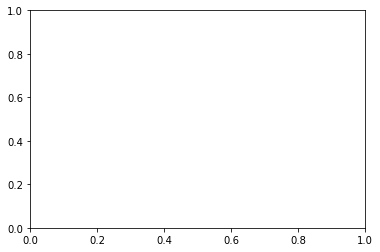

In [78]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(training_set):
     X_t = training_set[train_index]
     y_t = targets[train_index] 
     X_test = training_set[test_index]
     y_test = targets[test_index] 
     regr = RandomForestRegressor()
     results = regr.fit(X_t, y_t)
     y_prediciton = regr.predict(X_test)
     print("MAPE:")
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton)
     RSME_result = mean_squared_error(y_test, y_prediciton,squared = True)
     print("mapE:")
     print(MAPE_result)
     print("rseM:")
     print(RSME_result)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)
     print("---"*10)




## KNN

In [54]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(training_set):
     X_t = training_set[train_index]
     y_t = targets[train_index] 
     X_test = training_set[test_index]
     y_test = targets[test_index] 
     regr = KNeighborsRegressor()
     results = regr.fit(X_t, y_t)
     y_prediciton = regr.predict(X_test)
     print("MAPE:")
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton)
     RSME_result = mean_squared_error(y_test, y_prediciton,squared = True)
     print("mapE:")
     print(MAPE_result)
     print("rseM:")
     print(RSME_result)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)
     print("---"*10)



MAPE:
mapE:
0.2943208691281214
rseM:
2904.7940229885057
------------------------------
MAPE:
mapE:
0.25509491504721843
rseM:
2151.246896551724
------------------------------
MAPE:
mapE:
0.22227529186422457
rseM:
1745.8354022988506
------------------------------
MAPE:
mapE:
0.2735387629125807
rseM:
1956.9843678160921
------------------------------
MAPE:
mapE:
0.24801690889970085
rseM:
1537.416858237548
------------------------------
MAPE:
mapE:
0.20566839838613776
rseM:
1510.6740229885058
------------------------------
MAPE:
mapE:
0.2807713873765474
rseM:
1853.8767816091954
------------------------------
MAPE:
mapE:
0.2788198500437861
rseM:
1612.2122605363986
------------------------------
MAPE:
mapE:
0.20866756210326529
rseM:
2475.3020689655173
------------------------------
MAPE:
mapE:
0.2214707781144628
rseM:
1840.248735632184
------------------------------


## Decision Tree

In [55]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(training_set):
     X_t = training_set[train_index]
     y_t = targets[train_index] 
     X_test = training_set[test_index]
     y_test = targets[test_index] 
     regr = DecisionTreeClassifier()
     results = regr.fit(X_t, y_t)
     y_prediciton = regr.predict(X_test)
     print("MAPE:")
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton)
     RSME_result = mean_squared_error(y_test, y_prediciton,squared = True)
     print("mapE:")
     print(MAPE_result)
     print("rseM:")
     print(RSME_result)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)
     print("---"*10)



MAPE:
mapE:
0.5429898157480365
rseM:
16979.22988505747
------------------------------
MAPE:
mapE:
0.310563369529738
rseM:
6436.91570881226
------------------------------
MAPE:
mapE:
0.32870505263591765
rseM:
7308.340996168582
------------------------------
MAPE:
mapE:
0.2873126877522133
rseM:
5484.126436781609
------------------------------
MAPE:
mapE:
0.26737096914469244
rseM:
6203.75478927203
------------------------------
MAPE:
mapE:
0.29290073521257143
rseM:
5349.494252873563
------------------------------
MAPE:
mapE:
0.24811950232094812
rseM:
4724.065134099616
------------------------------
MAPE:
mapE:
0.2932705056989272
rseM:
5286.241379310345
------------------------------
MAPE:
mapE:
0.2302356133717877
rseM:
4652.544061302682
------------------------------
MAPE:
mapE:
0.2662322571618727
rseM:
5173.375478927203
------------------------------


## LinearSVM

In [59]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(training_set):
     X_t = training_set[train_index]
     y_t = targets[train_index] 
     X_test = training_set[test_index]
     y_test = targets[test_index] 
     regr = GradientBoostingRegressor()
     results = regr.fit(X_t, y_t)
     y_prediciton = regr.predict(X_test)
     print("MAPE:")
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton)
     RSME_result = mean_squared_error(y_test, y_prediciton,squared = True)
     print("mapE:")
     print(MAPE_result)
     print("rseM:")
     print(RSME_result)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)
     print("---"*10)



MAPE:
mapE:
0.22334837843091662
rseM:
1378.343923858673
------------------------------
MAPE:
mapE:
0.26550936008386744
rseM:
1519.2676907303824
------------------------------
MAPE:
mapE:
0.1927337377999799
rseM:
1322.3734979641383
------------------------------
MAPE:
mapE:
0.19256662125288265
rseM:
1210.2912551996499
------------------------------
MAPE:
mapE:
0.4398661176296213
rseM:
1340.0707122786146
------------------------------
MAPE:
mapE:
0.20208531341331368
rseM:
1138.6451568493846
------------------------------
MAPE:
mapE:
0.2321018371592622
rseM:
1271.8346511398242
------------------------------
MAPE:
mapE:
0.4343370058316428
rseM:
1283.291490294907
------------------------------
MAPE:
mapE:
0.2012599741117985
rseM:
2219.4581635185373
------------------------------
MAPE:
mapE:
0.2736039633737281
rseM:
1227.7172291800323
------------------------------


# LinearRegression

MAPE:
mapE:
0.778818316850932
rseM:
2200.8936810621944
------------------------------
MAPE:
mapE:
0.46385024344443493
rseM:
2373.019780162218
------------------------------
MAPE:
mapE:
0.799553989851901
rseM:
2143.181695349115
------------------------------
MAPE:
mapE:
1.098441221813767
rseM:
2905.66774723666
------------------------------
MAPE:
mapE:
1.112228539077371
rseM:
3217.334056801333
------------------------------
MAPE:
mapE:
0.3553934539652989
rseM:
1468.0451347811504
------------------------------
MAPE:
mapE:
0.4179125050815331
rseM:
1305.7215804904126
------------------------------
MAPE:
mapE:
0.5337319663313292
rseM:
2006.8764910573582
------------------------------
MAPE:
mapE:
0.4190554581894664
rseM:
2962.6923322147777
------------------------------
MAPE:
mapE:
0.8172809457577307
rseM:
1688.9855483808458
------------------------------


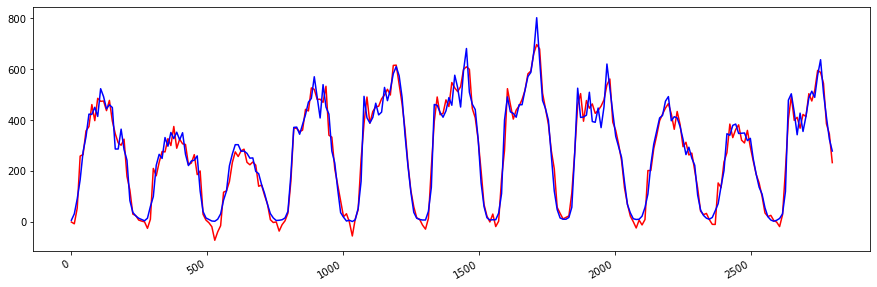

In [99]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(training_set):
     X_t = training_set[train_index]
     y_t = targets[train_index] 
     X_test = training_set[test_index]
     y_test = targets[test_index] 
     regr = LinearRegression()
     results = regr.fit(X_t, y_t)
     y_prediciton = regr.predict(X_test)
     print("MAPE:")
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton)
     RSME_result = mean_squared_error(y_test, y_prediciton,squared = True)
     print("mapE:")
     print(MAPE_result)
     print("rseM:")
     print(RSME_result)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)

     print("---"*10)
fig = plt.figure(figsize = (15,5))
plt.plot(np.linspace(1, 2800, num=261),np.array(y_prediciton),color ='red')
plt.plot(np.linspace(1, 2800, num=261),np.array(y_test),color ='blue')
fig.autofmt_xdate()

 # MLPRegressor


In [67]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(training_set):
     X_t = training_set[train_index]
     y_t = targets[train_index] 
     X_test = training_set[test_index]
     y_test = targets[test_index] 
     regr = MLPRegressor()
     results = regr.fit(X_t, y_t)
     y_prediciton = regr.predict(X_test)
     print("MAPE:")
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton)
     RSME_result = mean_squared_error(y_test, y_prediciton,squared = True)
     print("mapE:")
     print(MAPE_result)
     print("rseM:")
     print(RSME_result)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)
     print("---"*10)
fig = plt.figure(figsize = (15,5))
plt.plot(np.linspace(1, 2800, num=261),np.array(y_prediciton),color ='red')
plt.plot(np.linspace(1, 2800, num=261),np.array(y_test),color ='blue')
fig.autofmt_xdate()


MAPE:
mapE:
0.3871782745790078
rseM:
1566.9419915666085
------------------------------
MAPE:
mapE:
0.2961551630428984
rseM:
2433.5599655202836
------------------------------
MAPE:
mapE:
0.23150839139120893
rseM:
1551.8247341624099
------------------------------
MAPE:
mapE:
0.29320227584351516
rseM:
1118.5248767952467
------------------------------
MAPE:
mapE:
0.39087243190668547
rseM:
1305.5035917239625
------------------------------
MAPE:
mapE:
0.2659355659371687
rseM:
1060.448939302523
------------------------------
MAPE:
mapE:
0.26846951785951706
rseM:
1119.7735030036174
------------------------------
MAPE:
mapE:
0.26820169484627904
rseM:
1540.9215260575195
------------------------------
MAPE:
mapE:
0.23998310464280556
rseM:
2263.3333588695996
------------------------------
MAPE:
mapE:
0.5219892562687705
rseM:
1433.4051285500368
------------------------------


# SVR

In [71]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(training_set):
     X_t = training_set[train_index]
     y_t = targets[train_index] 
     X_test = training_set[test_index]
     y_test = targets[test_index] 
     regr = SVR(kernel = 'linear')
     results = regr.fit(X_t, y_t)
     y_prediciton = regr.predict(X_test)
     print("MAPE:")
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton)
     RSME_result = mean_squared_error(y_test, y_prediciton,squared = True)
     print("mapE:")
     print(MAPE_result)
     print("rseM:")
     print(RSME_result)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)
     print("---"*10)

MAPE:
mapE:
0.3212011394040052
rseM:
1721.0067334808398
------------------------------
MAPE:
mapE:
0.2774841766797204
rseM:
3054.5169237194536
------------------------------
MAPE:
mapE:
0.2826367886397355
rseM:
2106.7835775809085
------------------------------
MAPE:
mapE:
0.30501710631619383
rseM:
1365.7645834959908
------------------------------
MAPE:
mapE:
0.31134466264107735
rseM:
2105.5705219023557
------------------------------
MAPE:
mapE:
0.2493848728742782
rseM:
1794.8582203552596
------------------------------
MAPE:
mapE:
0.24228128744347366
rseM:
1208.3126167505836
------------------------------
MAPE:
mapE:
0.31453808434978175
rseM:
2275.9797415808835
------------------------------


KeyboardInterrupt: 